In [1]:
from pathlib import Path
import pygimli as pg  # Stelle sicher, dass das Modul pg importiert ist und verfügbar ist
from pygimli.physics import ert
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from datetime import datetime
import os
import numpy as np

from Hilfsfunktionen import T_corr_nach_Inversion
from Hilfsfunktionen import plotting_function
from Hilfsfunktionen import plotting_function_FTL

mod = []
mod_Tcorr = []
chi2_oT = []
rrms_oT = []
chi2_wT = []
rrms_wT = []
for sf, nr in zip([0.01, 0.3, 0.7, 1.9], [0,1,2,3]):
    file = "two_timesteps_240710_240808.ohm"
    two_timesteps = True
    base_dir = Path("filtered_data")
    data = []
    for unterordner in base_dir.iterdir():
        if unterordner.is_dir():
            datei_pfad = unterordner / "two_timesteps_240710_240808.ohm" 
            if datei_pfad.exists():
                daten_objekt = pg.load(str(datei_pfad))
                data.append([unterordner.name, daten_objekt])
                print(f"Load data: {datei_pfad}")
    
    # Create method manager
    manager = []
    for ts in data:
        manager.append(ert.ERTManager(ts[1], verbose=True))
    
    # Create mesh
    mesh = manager[0].createMesh(quality = 34, paraMaxCellSize=0.5, paraDepth=15)
    manager[0].invert(quality = 34, paraMaxCellSize=0.5, maxIter=1 ,dPhi= 0.1, paraDepth=15,lam=20)


    
    # Inversion without temperature correction
    DATA = [dat[1] for dat in data]
    # Full time-lapse
    scalef = sf
    fop = pg.frameworks.MultiFrameModelling(ert.ERTModelling, scalef=scalef)
    fop.setData(DATA)
    fop.setMesh(mesh)
    print(fop.mesh()) 
    dataVec = np.concatenate([data["rhoa"] for data in DATA])
    errorVec = np.concatenate([data["err"] for data in DATA])
    startModel = fop.createStartModel(dataVec)
    inv = pg.Inversion(fop=fop, startModel=startModel, verbose=True)
    model = inv.run(dataVec, errorVec, maxIter=10, lam= 15, startModel=startModel, verbose=True)
    chi2_oT.append(round(inv.chi2(),2))
    rrms_oT.append(round(inv.relrms(),2))
    mod.append(np.reshape(model, [len(DATA), -1]))

    # Temperature correction    
    ort_2 = 'Georg-Westermann-Park'
    mod_corr = []
    temp_spread = []
    timestep = 0
    mesh2 = manager[0].mesh.createSubMesh(manager[0].mesh.cells(manager[0].mesh.cellMarkers() == 2))
    for count, m in enumerate(mod[nr]):
        if two_timesteps:
            add = 10
        else:
            add = 0
        timestep = count+add
        dateien = os.listdir(r".\Temperature_data/" + ort_2 )
        for datei in dateien: 
            if (datei).startswith('T_Profil%s_array' % (str(timestep))):
                print(datei)
                Temp_tiefe_vektor = np.load(r'.\Temperature_data/%s/' % (ort_2) + datei, allow_pickle=True)
        res_new,Tem_new = T_corr_nach_Inversion(m, mesh2, Temp_tiefe_vektor)
        mod_corr.append(res_new)
        temp_spread.append(Tem_new)
    
    modell2 = np.reshape(mod[nr], -1)
    modell_corr = np.reshape(mod_corr, -1)
    response = inv.fop.response(modell2)
    response_t_corr = inv.fop.response(modell_corr)
    difference = response_t_corr - response
    diff = np.reshape(difference, [len(DATA), -1])
    for h in range(len(diff)):
        DATA[h]['rhoa'] = DATA[h]['rhoa'] + diff[h]
        
        
    # Inversion with temperature correction
    fop = pg.frameworks.MultiFrameModelling(ert.ERTModelling, scalef=scalef)
    fop.setData(DATA)
    fop.setMesh(mesh)
    print(fop.mesh())  
    dataVec = np.concatenate([data["rhoa"] for data in DATA])
    errorVec = np.concatenate([data["err"] for data in DATA])
    startModel = fop.createStartModel(dataVec)
    inv = pg.Inversion(fop=fop, startModel=startModel, verbose=True)
    model = inv.run(dataVec, errorVec, maxIter=10, lam= 15, startModel=startModel, verbose=True)
    
    chi2_wT.append(round(inv.chi2(),2))
    rrms_wT.append(round(inv.relrms(),2))
    mod_Tcorr.append(np.reshape(model, [len(DATA), -1]))
    

[NbConvertApp] Converting notebook Hilfsfunktionen.ipynb to script
[NbConvertApp] Writing 24706 bytes to Hilfsfunktionen.py


Load data: filtered_data\240710\two_timesteps_240710_240808.ohm
Load data: filtered_data\240808\two_timesteps_240710_240808.ohm


24/04/25 - 03:16:10 - pyGIMLi - INFO - Found 2 regions.
24/04/25 - 03:16:10 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
24/04/25 - 03:16:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
24/04/25 - 03:16:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
24/04/25 - 03:16:11 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 8540 Cells: 16788 Boundaries: 12736
24/04/25 - 03:16:12 - pyGIMLi - INFO - Use median(data values)=2043.9
24/04/25 - 03:16:12 - pyGIMLi - INFO - Created startmodel from forward operator: 3104, min/max=2043.900000/2043.900000
24/04/25 - 03:16:12 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000002971A64AF20>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000002971A64B1A0>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x000002971A64B060>
min/max (data): 65.6/6396
min/max (error): 3%/3.02%
min/max (start model): 2044/2044
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 1125.22
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   28.56 (dPhi = 96.71%) lam: 20.0


24/04/25 - 03:17:28 - pyGIMLi - INFO - Found 2 regions.
24/04/25 - 03:17:28 - pyGIMLi - INFO - Region with smallest marker (1) set to background
24/04/25 - 03:17:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
24/04/25 - 03:17:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
24/04/25 - 03:17:29 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 8540 Cells: 16788 Boundaries: 12736
24/04/25 - 03:17:30 - pyGIMLi - INFO - Starting inversion.


3104 model cells
Mesh: Nodes: 8540 Cells: 16788 Boundaries: 12736
fop: <pygimli.frameworks.timelapse.MultiFrameModelling object at 0x000002977F7DD490>
Data transformation: <pgcore._pygimli_.RTrans object at 0x000002971A654890>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x000002977F85BB50>
min/max (data): 65.6/6396
min/max (error): 3%/3.02%
min/max (start model): 1951/1951
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 17975.09
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =  417.99 (dPhi = 97.65%) lam: 15.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =  141.76 (dPhi = 65.93%) lam: 15.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    3.05 (dPhi = 96.24%) lam: 15.0
--------------------------------------------------------------------------------
inv.

24/04/25 - 03:26:29 - pyGIMLi - INFO - Found 2 regions.
24/04/25 - 03:26:29 - pyGIMLi - INFO - Region with smallest marker (1) set to background
24/04/25 - 03:26:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
24/04/25 - 03:26:30 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
24/04/25 - 03:26:30 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 8540 Cells: 16788 Boundaries: 12736


3104 model cells
Mesh: Nodes: 8540 Cells: 16788 Boundaries: 12736


24/04/25 - 03:26:31 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.frameworks.timelapse.MultiFrameModelling object at 0x0000029719BA86D0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x000002971A654890>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x000002977F80BD80>
min/max (data): 38.2/5124
min/max (error): 3%/3.02%
min/max (start model): 1490/1490
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 24740.67
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =  639.91 (dPhi = 97.39%) lam: 15.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =  277.42 (dPhi = 56.59%) lam: 15.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    5.64 (dPhi = 97.01%) lam: 15.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    3.94 (dPhi = 25.07%) lam: 15.0
--------------

24/04/25 - 03:33:21 - pyGIMLi - INFO - Found 2 regions.
24/04/25 - 03:33:21 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
24/04/25 - 03:33:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
24/04/25 - 03:33:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
24/04/25 - 03:33:22 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 8540 Cells: 16788 Boundaries: 12736
24/04/25 - 03:33:22 - pyGIMLi - INFO - Use median(data values)=2043.9
24/04/25 - 03:33:22 - pyGIMLi - INFO - Created startmodel from forward operator: 3104, min/max=2043.900000/2043.900000
24/04/25 - 03:33:22 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000002977F51A200>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000002971A64BBA0>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x000002971901E480>
min/max (data): 65.6/6396
min/max (error): 3%/3.02%
min/max (start model): 2044/2044
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 1125.22
--------------------------------------------------------------------------------
inv.iter 1 ... 

24/04/25 - 03:34:27 - pyGIMLi - INFO - Found 2 regions.
24/04/25 - 03:34:27 - pyGIMLi - INFO - Region with smallest marker (1) set to background
24/04/25 - 03:34:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
24/04/25 - 03:34:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


chi² =   28.57 (dPhi = 96.71%) lam: 20.0


24/04/25 - 03:34:28 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 8540 Cells: 16788 Boundaries: 12736


3104 model cells
Mesh: Nodes: 8540 Cells: 16788 Boundaries: 12736


24/04/25 - 03:34:29 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.frameworks.timelapse.MultiFrameModelling object at 0x000002971A64BD80>
Data transformation: <pgcore._pygimli_.RTrans object at 0x000002971A6560A0>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x000002971A64BA60>
min/max (data): 65.6/6396
min/max (error): 3%/3.02%
min/max (start model): 1951/1951
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 17975.09
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =  417.49 (dPhi = 97.65%) lam: 15.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =  142.68 (dPhi = 65.68%) lam: 15.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    3.00 (dPhi = 96.27%) lam: 15.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    2.13 (dPhi = 20.13%) lam: 15.0
--------------

24/04/25 - 03:42:47 - pyGIMLi - INFO - Found 2 regions.
24/04/25 - 03:42:47 - pyGIMLi - INFO - Region with smallest marker (1) set to background
24/04/25 - 03:42:47 - pyGIMLi - INFO - Creating forward mesh from region infos.
24/04/25 - 03:42:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
24/04/25 - 03:42:48 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 8540 Cells: 16788 Boundaries: 12736


3104 model cells
Mesh: Nodes: 8540 Cells: 16788 Boundaries: 12736


24/04/25 - 03:42:50 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.frameworks.timelapse.MultiFrameModelling object at 0x0000029719BA86D0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x000002971A656AB0>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x000002971A555C10>
min/max (data): 38.27/5125
min/max (error): 3%/3.02%
min/max (start model): 1490/1490
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 24625.92
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =  636.43 (dPhi = 97.39%) lam: 15.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =  274.71 (dPhi = 56.78%) lam: 15.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    5.54 (dPhi = 97.01%) lam: 15.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    3.85 (dPhi = 25.30%) lam: 15.0
-------------

24/04/25 - 03:50:09 - pyGIMLi - INFO - Found 2 regions.
24/04/25 - 03:50:09 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
24/04/25 - 03:50:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
24/04/25 - 03:50:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
24/04/25 - 03:50:09 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 8540 Cells: 16788 Boundaries: 12736
24/04/25 - 03:50:09 - pyGIMLi - INFO - Use median(data values)=2043.9
24/04/25 - 03:50:09 - pyGIMLi - INFO - Created startmodel from forward operator: 3104, min/max=2043.900000/2043.900000
24/04/25 - 03:50:09 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000002971A3190D0>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000002971A64B060>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x000002971A64B830>
min/max (data): 65.6/6396
min/max (error): 3%/3.02%
min/max (start model): 2044/2044
--------------------------------------------------------------------------------


24/04/25 - 03:50:50 - pyGIMLi - INFO - Found 2 regions.
24/04/25 - 03:50:50 - pyGIMLi - INFO - Region with smallest marker (1) set to background
24/04/25 - 03:50:50 - pyGIMLi - INFO - Creating forward mesh from region infos.


inv.iter 0 ... chi² = 1125.22
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   28.57 (dPhi = 96.71%) lam: 20.0


24/04/25 - 03:50:50 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
24/04/25 - 03:50:51 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 8540 Cells: 16788 Boundaries: 12736


3104 model cells
Mesh: Nodes: 8540 Cells: 16788 Boundaries: 12736


24/04/25 - 03:50:52 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.frameworks.timelapse.MultiFrameModelling object at 0x000002971A64B740>
Data transformation: <pgcore._pygimli_.RTrans object at 0x000002971A656880>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x000002971A64B510>
min/max (data): 65.6/6396
min/max (error): 3%/3.02%
min/max (start model): 1951/1951
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 17975.09
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =  414.88 (dPhi = 97.66%) lam: 15.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =  142.20 (dPhi = 65.57%) lam: 15.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    3.02 (dPhi = 96.16%) lam: 15.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    2.15 (dPhi = 19.39%) lam: 15.0
--------------

24/04/25 - 03:59:17 - pyGIMLi - INFO - Found 2 regions.
24/04/25 - 03:59:17 - pyGIMLi - INFO - Region with smallest marker (1) set to background
24/04/25 - 03:59:17 - pyGIMLi - INFO - Creating forward mesh from region infos.
24/04/25 - 03:59:17 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
24/04/25 - 03:59:17 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 8540 Cells: 16788 Boundaries: 12736


3104 model cells
Mesh: Nodes: 8540 Cells: 16788 Boundaries: 12736


24/04/25 - 03:59:19 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.frameworks.timelapse.MultiFrameModelling object at 0x0000029719F56570>
Data transformation: <pgcore._pygimli_.RTrans object at 0x000002971A656880>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x000002977F9085E0>
min/max (data): 38.29/5131
min/max (error): 3%/3.02%
min/max (start model): 1490/1490
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 24626.41
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =  634.12 (dPhi = 97.40%) lam: 15.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =  279.26 (dPhi = 55.92%) lam: 15.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    5.62 (dPhi = 96.99%) lam: 15.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    3.88 (dPhi = 25.19%) lam: 15.0
-------------

24/04/25 - 04:06:06 - pyGIMLi - INFO - Found 2 regions.
24/04/25 - 04:06:06 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
24/04/25 - 04:06:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
24/04/25 - 04:06:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
24/04/25 - 04:06:07 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 8540 Cells: 16788 Boundaries: 12736
24/04/25 - 04:06:07 - pyGIMLi - INFO - Use median(data values)=2043.9
24/04/25 - 04:06:07 - pyGIMLi - INFO - Created startmodel from forward operator: 3104, min/max=2043.900000/2043.900000
24/04/25 - 04:06:07 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000002971A318D10>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000002971A64BDD0>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x0000029719AE54E0>
min/max (data): 65.6/6396
min/max (error): 3%/3.02%
min/max (start model): 2044/2044
--------------------------------------------------------------------------------


24/04/25 - 04:07:11 - pyGIMLi - INFO - Found 2 regions.
24/04/25 - 04:07:11 - pyGIMLi - INFO - Region with smallest marker (1) set to background
24/04/25 - 04:07:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
24/04/25 - 04:07:11 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


inv.iter 0 ... chi² = 1125.22
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   28.58 (dPhi = 96.71%) lam: 20.0


24/04/25 - 04:07:11 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 8540 Cells: 16788 Boundaries: 12736


3104 model cells
Mesh: Nodes: 8540 Cells: 16788 Boundaries: 12736


24/04/25 - 04:07:13 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.frameworks.timelapse.MultiFrameModelling object at 0x000002971A64AD40>
Data transformation: <pgcore._pygimli_.RTrans object at 0x000002971A656CE0>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x000002971A6906D0>
min/max (data): 65.6/6396
min/max (error): 3%/3.02%
min/max (start model): 1951/1951
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 17975.09
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =  413.29 (dPhi = 97.67%) lam: 15.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =  146.36 (dPhi = 64.36%) lam: 15.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    3.25 (dPhi = 95.63%) lam: 15.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    2.35 (dPhi = 17.09%) lam: 15.0
--------------

24/04/25 - 04:14:38 - pyGIMLi - INFO - Found 2 regions.
24/04/25 - 04:14:38 - pyGIMLi - INFO - Region with smallest marker (1) set to background
24/04/25 - 04:14:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
24/04/25 - 04:14:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
24/04/25 - 04:14:39 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 8540 Cells: 16788 Boundaries: 12736


3104 model cells
Mesh: Nodes: 8540 Cells: 16788 Boundaries: 12736


24/04/25 - 04:14:40 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.frameworks.timelapse.MultiFrameModelling object at 0x000002971A3190D0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x000002971A656D50>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x000002977F80BD80>
min/max (data): 38.33/5156
min/max (error): 3%/3.02%
min/max (start model): 1490/1490
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 24646.57
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =  638.85 (dPhi = 97.38%) lam: 15.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =  295.86 (dPhi = 53.62%) lam: 15.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    6.23 (dPhi = 96.72%) lam: 15.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    3.87 (dPhi = 27.83%) lam: 15.0
-------------

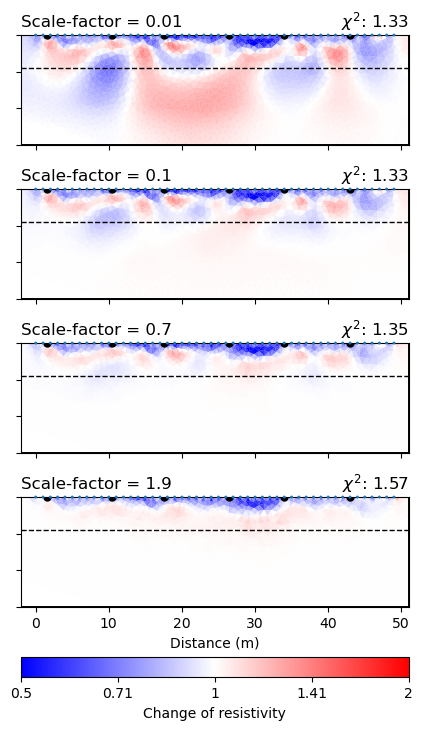

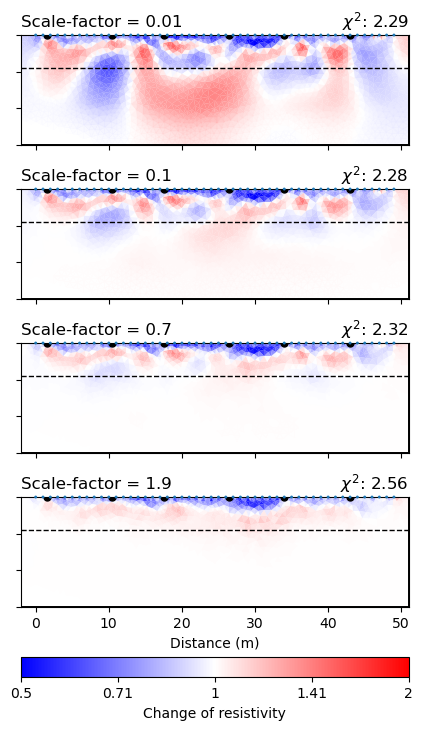

In [3]:
# Veränderung im Vergleich zu vorherigem


for chi2, m, name in zip([chi2_oT, chi2_wT], [mod, mod_Tcorr], ['withoutTcorr', 'withTcorr']):
    fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(5, 4*2.5))
    plt.subplots_adjust(hspace=-0.5)
    for nr, sf in zip([0,1,2,3], [0.01,0.1,0.7,1.9]):
        ratio = m[nr][1] / m[nr][0]
        bild2 = manager[0].showResult(model= ratio,coverage = manager[0].coverage(),
                cMin=1/2, cMax=2, cMap= 'bwr', ax= axs[nr], label = 'Change of resistivity', logScale= True)
        if nr < 3:
            cb = bild2[-1]
            cb.remove() 
            axs[nr].xaxis.set_ticklabels([])  # Unterdrückt die x-Achse Labels
        if nr == 3:
            axs[nr].set_xlabel('Distance (m)')
            
        axs[nr].yaxis.set_ticklabels([])  # Unterdrückt die y-Achse Labels
        axs[nr].set_title('$\chi^2$: '+ str(chi2[nr]), loc = 'right')
        axs[nr].set_title('Scale-factor = '+ str(sf), loc = 'left')
        # Prinzenpark
        axs[nr].plot(1.5,0, '.', markersize = '10', color = 'black')
        axs[nr].plot(10.5,0, '.', markersize = '10', color = 'black')
        axs[nr].plot(17.5,0, '.', markersize = '10', color = 'black')
        axs[nr].plot(26.5,0, '.', markersize = '10', color = 'black')
        axs[nr].plot(34,0, '.', markersize = '10 ', color = 'black')
        axs[nr].plot(43,0, '.', markersize = '10 ', color = 'black')
        axs[nr].set_ylim(-15, 0)
        axs[nr].axhline(y=-4.5, color='k', linewidth = 1,linestyle='--')
    
    fig.savefig('./Fig7_8/Lam15_%s_Fehler3.png' % name, bbox_inches = 'tight', dpi=300)